First, we will take the BikeLane GeoJSON (2023) and grab the coordinates of each bike lane in the dataset. 

In [90]:
import geopandas as gpd

df = gpd.read_file('Existing_Bike_Network_2023.geojson')
# print(df.geometry.iloc[0].coords[0][0])

Then, we will call the GeoCoder API from the US Government to determine which Census Tract each bike lane segment belongs to.

In [29]:
import requests

df = df.dropna()
def get_census_tract(lat, long):
    url = f'https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x={lat}&y={long}&benchmark=Public_AR_Census2020&vintage=Census2020_Census2020&format=json'
    response = requests.get(url)
    data = response.json()
    
    census_tract = data['result']['geographies']['Census Tracts'][0]['BASENAME']
    return census_tract

def process_row(row):
    lat, long = row.geometry.coords[0][0], row.geometry.coords[0][1]
    census_tract = get_census_tract(lat, long)
    return census_tract

# just so if it errors we don't lose all progress
output_file = 'census_tracts.txt'

with open(output_file, 'a') as f:
    for idx, row in df.iterrows():
        try:
            census_tract = process_row(row)
            f.write(f'{census_tract}\n')
            print(f'row {idx + 1} done')
        except Exception as e:
            print(f'error in row {idx + 1}: {e}')

row 1 done
row 2 done
row 3 done
row 4 done
row 5 done
row 6 done
row 7 done
row 8 done
row 9 done
row 10 done
row 11 done
row 12 done
row 13 done
row 14 done
row 15 done
row 16 done
row 17 done
row 18 done
row 19 done
row 20 done
row 21 done
row 22 done
row 23 done
row 24 done
row 25 done
row 26 done
row 27 done
row 28 done
row 29 done
row 30 done
row 31 done
row 32 done
row 33 done
row 34 done
row 35 done
row 36 done
row 37 done
row 38 done
row 39 done
row 40 done
row 41 done
row 42 done
row 43 done
row 44 done
row 45 done
row 46 done
row 47 done
row 48 done
row 49 done
row 50 done
row 51 done
row 52 done
row 53 done
row 54 done
row 55 done
row 56 done
row 57 done
row 58 done
row 59 done
row 60 done
row 61 done
row 62 done
row 63 done
row 64 done
row 65 done
row 66 done
row 67 done
row 68 done
row 69 done
row 70 done
row 71 done
row 72 done
row 73 done
row 74 done
row 75 done
row 76 done
row 77 done
row 78 done
row 79 done
row 80 done
row 81 done
row 82 done
row 83 done
row 84 done
r

Import the census tracts gotten into the dataframe so each bike lane can be labeled by their census tract.

In [91]:
import pandas as pd

data = pd.read_csv('census_tracts.txt', header=None)
df['census'] = data
df.head()


,FID,STREET_NAM,ROADINVENT,FUNCTIONAL,JURISDICTI,Divided,InstallDat,ExisFacil,Shape_Leng,Shape__Length,geometry,census
0,1,Veterans Of Foreign Wars Parkway,6212500,2,3,1,2013,BL,175.249590,175.249590,"LINESTRING (-71.16828 42.29067, -71.16840 42.2...",1301.01
1,2,Veterans Of Foreign Wars Parkway,4847800,2,3,1,2013,BL,82.501161,82.501161,"LINESTRING (-71.16811 42.29049, -71.16777 42.2...",1301.01
2,3,Veterans Of Foreign Wars Parkway,4838800,2,3,1,2013,BL,81.227024,81.227024,"LINESTRING (-71.16656 42.29131, -71.16574 42.2...",1301.01
3,4,Lake Street,4547801,6,2,0,2010,SLM,137.040790,137.040790,"LINESTRING (-71.16612 42.34068, -71.16611 42.3...",3.02
4,5,Commonwealth Avenue,5141000,3,2,1,2013,SLM,213.655205,213.655205,"LINESTRING (-71.16612 42.33996, -71.16554 42.3...",5.02


Get landmass of census tracts (so we can scale them with bike lane data -- larger tracts shouldn't have arbitrarily larger numbers)

In [143]:
path_to_shapefile = 'tract_areas.zip'

gdf = gpd.read_file(path_to_shapefile)

gdf = gdf.to_crs(epsg=2249)

gdf['area_sq_m'] = gdf.geometry.area
gdf['area_sq_km'] = gdf['area_sq_m'] / 10**6

# Display the resulting GeoDataFrame
gdf = gdf[['NAME', 'area_sq_km']]
print(gdf.head())

      NAME  area_sq_km
0  3362.02   11.378181
1  3301.02  106.036769
2  3391.01    9.590139
3  3567.03   16.263195
4  3302.02   83.121202


We can assume that streets have unique names. If a street spans multiple census tracts, it will be counted in both tracts -- however repeat streets in one census tract will not count.

We can calculate the "bikelane frequency" a census tract has by adding up the number of unique streets with a bike lane a given census tract has.

In [164]:
import math

census_bikelane_freq = {}

for _, row in df.iterrows():
    if math.isnan(float(row['census'])):
        continue
    if row['census'] not in census_bikelane_freq:
        census_bikelane_freq[row['census']] = [row['STREET_NAM']]
    else:
        if row['STREET_NAM'] not in census_bikelane_freq[row['census']]:
            census_bikelane_freq[row['census']].append(row['STREET_NAM'])

for key in census_bikelane_freq:
    census_bikelane_freq[key] = len(census_bikelane_freq[key])

# for _, row in df.iterrows():
#     if math.isnan(float(row['census'])):
#         continue
#     if row['census'] not in census_bikelane_freq:
#         census_bikelane_freq[row['census']] = row['Shape_Leng']
#     else:
#         census_bikelane_freq[row['census']] += row['Shape_Leng']

exists = []
for key in census_bikelane_freq:
    if str(key) in gdf['NAME'].values:
        census_bikelane_freq[key] /= gdf.loc[gdf['NAME'] == str(key)]['area_sq_km'].values[0]
    else:
        exists.append(key)
    
for key in exists:
    del census_bikelane_freq[key]

# testing connectivity
tract_span_street = {}
for _, row in df.iterrows():
    if row['STREET_NAM'] not in tract_span_street:
        tract_span_street[row['STREET_NAM']] = [row['census']]
    else:
        if row['census'] not in tract_span_street[row['STREET_NAM']]:
            tract_span_street[row['STREET_NAM']].append(row['census'])

census_bikelane_connectivity = {}
for street in tract_span_street:
    if len(tract_span_street[street]) == 1:
        continue
    for census in tract_span_street[street]: 
        if census not in census_bikelane_connectivity:
            census_bikelane_connectivity[census] = len(tract_span_street[street]) ** 1.2
        else:
            census_bikelane_connectivity[census] += len(tract_span_street[street]) ** 1.2

exists = []
for key in census_bikelane_connectivity:
    if str(key) in gdf['NAME'].values:
        census_bikelane_connectivity[key] /= gdf.loc[gdf['NAME'] == str(key)]['area_sq_km'].values[0]
    else:
        exists.append(key)
    
for key in exists:
    del census_bikelane_connectivity[key]

print(census_bikelane_connectivity)

print(census_bikelane_freq)
# print(census_bikelane_freq.keys())

{1301.01: 26.467658184343723, 3.02: 64.62424586916802, 2.01: 146.49200330736394, 5.02: 71.41568975870875, 8.06: 67.21945393683067, 2.02: 144.5112275868069, 910.01: 28.13365082675523, 9812.01: 31.48364148478028, 1006.03: 67.36181121641033, 606.04: 46.448904184795545, 501.01: 84.00731913976097, 1.02: 80.64084392622225, 509.01: 16.372549732542556, 4.02: 64.01904133239361, 1106.07: 79.86317628025176, 606.03: 173.73490312863078, 1304.02: 22.115176535997062, 909.01: 66.06416120737002, 511.01: 19.297988940458563, 3.01: 45.88738804821444, 4012.01: 2.0601048375950324, 303.02: 149.27371728790112, 303.01: 37.648497474051865, 1401.07: 98.17750535498108, 1104.01: 59.7570646235636, 8.04: 149.9672733711192, 1011.01: 61.40207244934499, 813.02: 145.16625833575156, 104.03: 221.4528042351719, 6.01: 166.44662805814906, 1103.01: 48.831877480584275, 1201.05: 40.36601213522632, 808.01: 77.94620852585878, 104.04: 322.40406582090526, 806.01: 153.24059628398163, 108.02: 559.4086750511749, 1402.02: 24.1588503138

Process commute data so we can work with it (getting rid of unnecessary demographic related information, and non-bike related information)

In [106]:
commute = pd.read_csv('Commute Data.csv')
commute = commute.iloc[[11]] # keeps only bike commute rate
commute = commute.iloc[:, 1::3] # keeps only total estimates, not male or female specific

new_column_names = []

for column_name in commute.columns:
    words = column_name.split()
    if len(words) >= 3:
        new_column_name = words[2]  # extract the census number from the original column name
    else:
        new_column_name = column_name  # edge case
    new_column_names.append(new_column_name[:-1])

# Rename the columns
commute.columns = new_column_names

commute.head()

,1.01,1.02,2.01,2.02,3.01,3.02,4.01,4.02,5.02,5.03,...,9812.01,9812.02,9813,9815.01,9815.02,9816,9817,9818,9819,9901.01
11,8.5%,2.1%,1.2%,0.6%,0.3%,0.3%,1.4%,0.5%,1.2%,0.6%,...,-,0.0%,0.0%,-,-,-,-,0.0%,-,-


Now we can zip up the census tract bike usage with the bike-lane-frequency number obtained earlier with the census tract as the key. This will find the correlation between bike lane usage and frequency of bike lane in a given census tract.

In [165]:
frequency_trend = []

row = commute.iloc[0]

for col, val in row.items():
    if val == '-':
        continue
    cen = float(col)
    if cen in census_bikelane_freq:
        frequency_trend.append( (float(val.strip('%')), census_bikelane_freq[cen]) )
    # print(f"Column name: {col}, Value: {val}")

connectivity_trend = []
for col, val in row.items():
    if val == '-':
        continue
    cen = float(col)
    if cen in census_bikelane_connectivity:
        connectivity_trend.append( (float(val.strip('%')), census_bikelane_connectivity[cen]) )
    # print(f"Column name: {col}, Value: {val}")

print(frequency_trend)
print(connectivity_trend)
# print(commute.iloc[0]['8.06'])

[(8.5, 2.6022428946625342), (2.1, 1.827834005669906), (1.2, 3.100979978501708), (0.6, 2.470841532660258), (0.3, 1.3007248116426127), (0.3, 1.3145920123219152), (1.4, 1.5088209654393998), (0.5, 1.266786717168747), (1.2, 1.2574075331933117), (0.6, 3.3194613745945123), (4.5, 1.9304302121786854), (2.7, 0.9836537698921185), (1.0, 3.3766981989522726), (0.0, 1.1892876595883477), (8.4, 1.2946120922005053), (5.5, 1.6127465343365832), (4.6, 8.87346089053092), (5.9, 1.1624389478883763), (5.9, 2.905340476325973), (5.7, 2.009514640579005), (5.0, 1.1800639924709626), (0.0, 4.675390183675462), (0.5, 4.8372526098310304), (3.6, 4.53696381197121), (3.9, 9.144147203797813), (7.8, 3.0499812373053947), (0.0, 0.003977795254255907), (4.8, 3.1475851520881486), (0.3, 2.7144763090883264), (2.9, 4.837782190911365), (0.1, 5.518794487939186), (0.5, 4.333221542551188), (3.4, 5.629257264974704), (4.1, 6.516649507040113), (2.8, 1.694069053347145), (0.7, 7.409725507950103), (0.7, 1.2099826015048791), (1.9, 4.483598945

Now we can graph this list of tuples to see if there exists a trend!

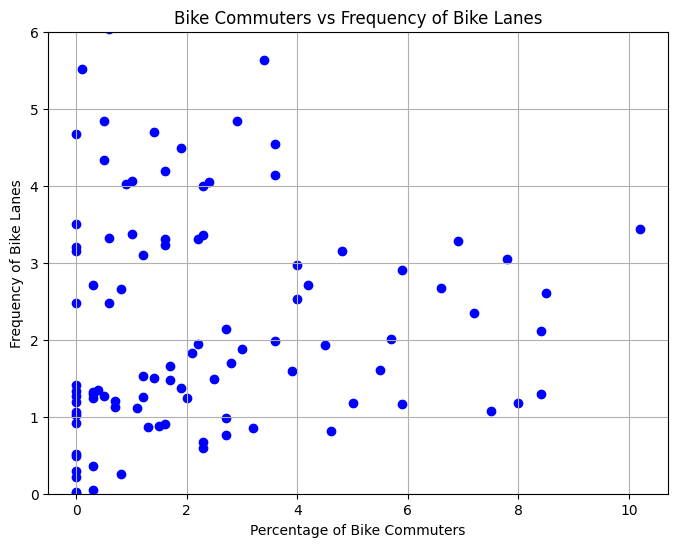

In [166]:
import matplotlib.pyplot as plt

bike_usage = [item[0] for item in frequency_trend]  # percentage of bike commuters
lane_freq = [item[1] for item in frequency_trend]  # freq of bike lanes

plt.figure(figsize=(8, 6))
plt.scatter(bike_usage, lane_freq, marker='o', color='blue')
plt.ylim(0, 6)
plt.xlabel('Percentage of Bike Commuters')
plt.ylabel('Frequency of Bike Lanes')
plt.title('Bike Commuters vs Frequency of Bike Lanes')
plt.grid(True)
plt.show()

Now we will plot the connectivity graph.

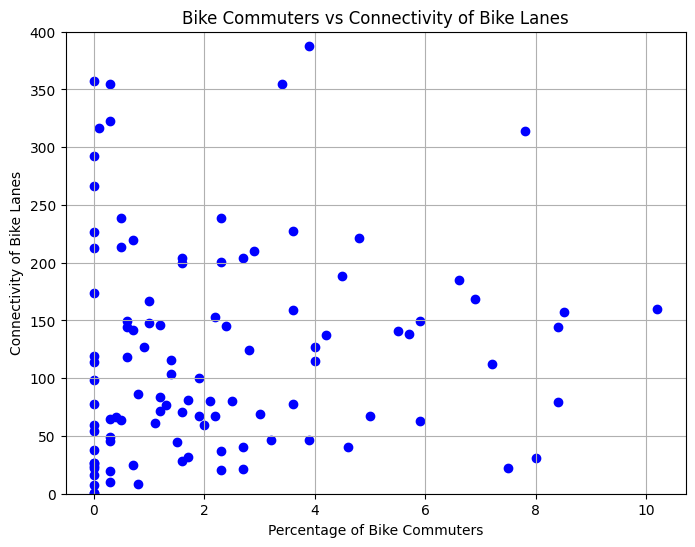

In [168]:
import matplotlib.pyplot as plt

bike_usage = [item[0] for item in connectivity_trend]  # percentage of bike commuters
lane_connectivity = [item[1] for item in connectivity_trend]  # freq of bike lanes

plt.figure(figsize=(8, 6))
plt.scatter(bike_usage, lane_connectivity, marker='o', color='blue')
plt.ylim(0, 400)
plt.xlabel('Percentage of Bike Commuters')
plt.ylabel('Connectivity of Bike Lanes')
plt.title('Bike Commuters vs Connectivity of Bike Lanes')
plt.grid(True)
plt.show()